In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
sns.set_style("darkgrid")

2023-09-04 13:14:45.267890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 13:14:45.455934: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-04 13:14:46.185257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-04 13:14:46.185363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Path for csv files
files_path ='../../raw_data/data_1year/'

# Num of trips
df = pd.read_csv(files_path + 'results.csv', index_col='timestamp')

In [3]:
# Load features
features_preproc = pd.read_csv(files_path + 'final_features_preproc_12m.csv')
features_preproc.set_index(features_preproc.columns[0],inplace=True)

# Change 2s
features_preproc["event_title_nan"] = features_preproc["event_title_nan"].apply(lambda x: 1 if x>=1 else 0)

# Change names
features_preproc.rename(columns={"event_title_nan": "no_event"}, inplace=True)

#Drop Columns
features_preproc.drop(columns=['minute','second','London_zone_London_all'], inplace=True)

In [4]:
df = df.join(features_preproc)

In [5]:
# Converting the index as date
df.index = pd.to_datetime(df.index)

In [6]:
df.columns

Index(['nooftrips', 'temperature', 'rainfall', 'snowfall', 'cloudcover',
       'wind_speed', 'wind_direction', 'daytime', 'London_zone_Central',
       'London_zone_South_East', 'London_zone_East', 'London_zone_North',
       'London_zone_South_West', 'London_zone_West', 'elisabeth_line',
       'lockdown', 'school_holidays', 'strike', 'year', 'month', 'day', 'hour',
       'weekday',
       'event_title_Bank Holiday for the State Funeral of Queen Elizabeth II',
       'event_title_Boxing Day', 'event_title_Champions League Final',
       'event_title_Chelsea Flower Show', 'event_title_Christmas Day',
       'event_title_Diwali on Trafalgar Square',
       'event_title_Early May bank holiday', 'event_title_Easter Monday',
       'event_title_Frieze Art Fair', 'event_title_Good Friday',
       'event_title_Guy Fawkes Night (Bonfire Night)',
       'event_title_Halloween in London', 'event_title_London Film Festival',
       'event_title_London Marathon', 'event_title_New Year's Eve Fir

In [7]:
df = df[['nooftrips', 'temperature', 'rainfall', 'snowfall', 'cloudcover',
       'wind_speed', 'wind_direction','weekday','strike', 'school_holidays']]

In [8]:
df['hour'] = df.index.hour
df['weekday'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month

In [9]:
df.head()

,nooftrips,temperature,rainfall,snowfall,cloudcover,wind_speed,wind_direction,weekday,strike,school_holidays,hour,day,month
timestamp,,,,,,,,,,,,,
2022-01-02 00:00:00,200,0.429952,0.010204,0.0,1.0,0.108333,0.523677,6,0,1,0,2,1
2022-01-02 01:00:00,94,0.427536,0.010204,0.0,1.0,0.330000,0.662953,6,0,1,1,2,1
2022-01-02 02:00:00,41,0.427536,0.000000,0.0,1.0,0.310000,0.668524,6,0,1,2,2,1
2022-01-02 03:00:00,50,0.427536,0.000000,0.0,1.0,0.283333,0.688022,6,0,1,3,2,1
2022-01-02 04:00:00,62,0.427536,0.000000,0.0,1.0,0.283333,0.688022,6,0,1,4,2,1


<Axes: xlabel='timestamp', ylabel='nooftrips'>

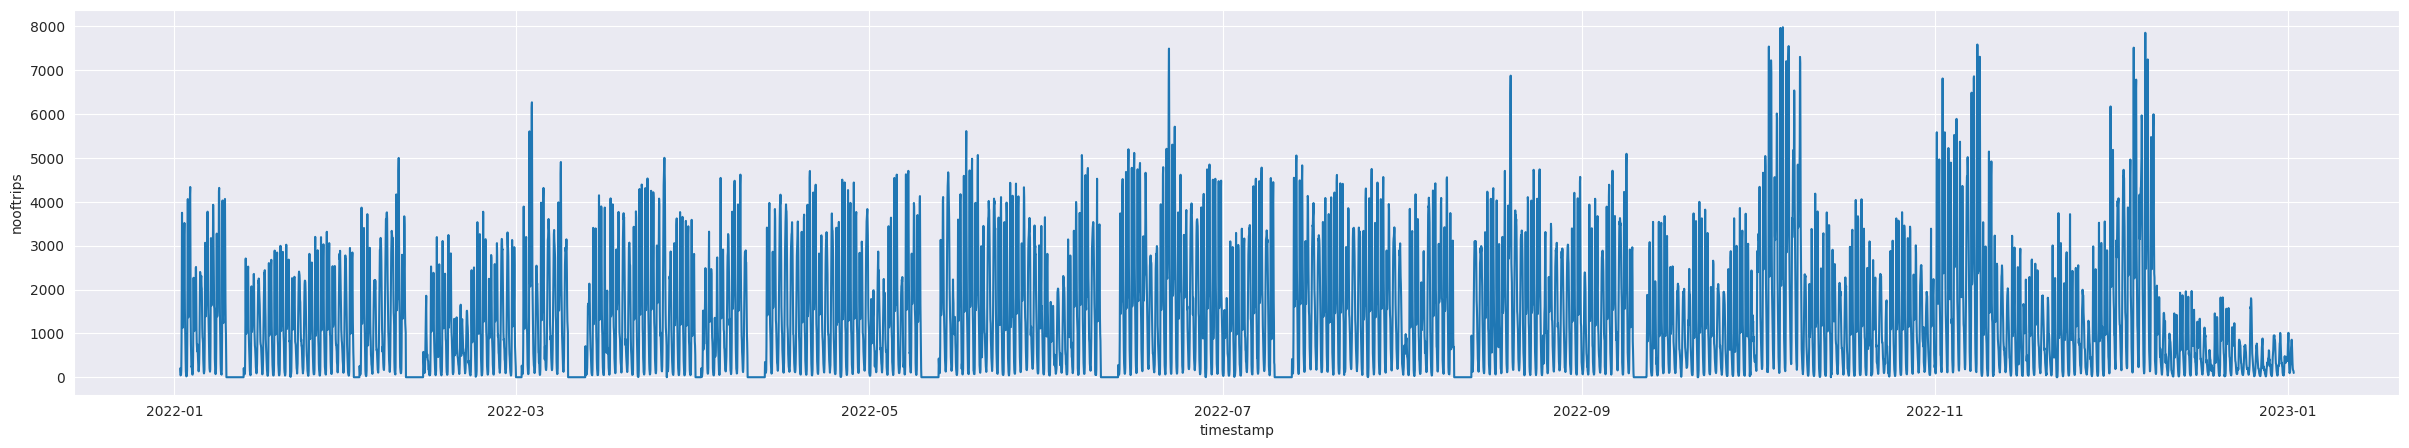

In [10]:
plt.figure(figsize=(30, 5))
sns.lineplot(x=df.index, y='nooftrips',data=df)

<Axes: xlabel='timestamp', ylabel='nooftrips'>

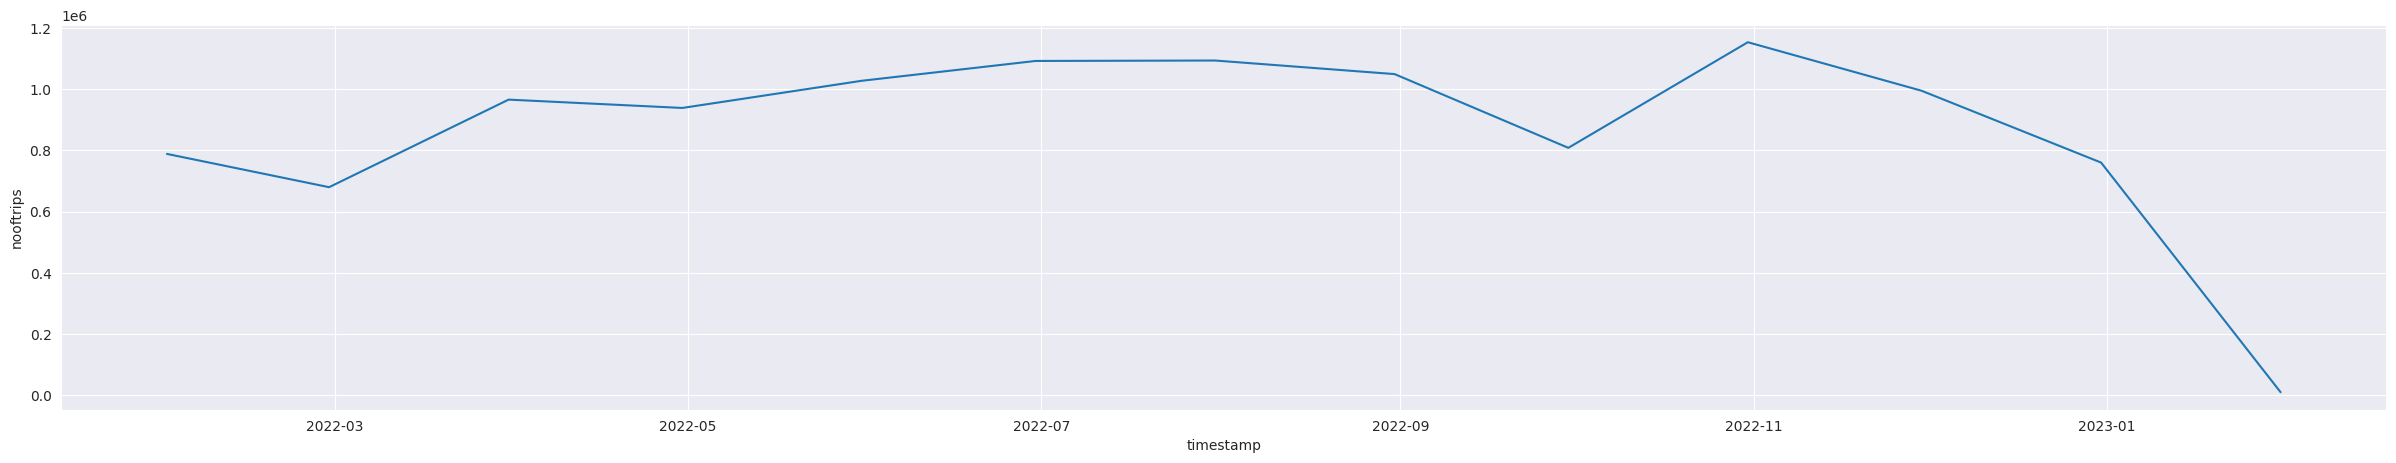

In [11]:
df_by_month = df.resample('M').sum()
plt.figure(figsize=(30,5))
sns.lineplot(x=df_by_month.index, y='nooftrips',data=df_by_month)

<Axes: xlabel='hour', ylabel='nooftrips'>

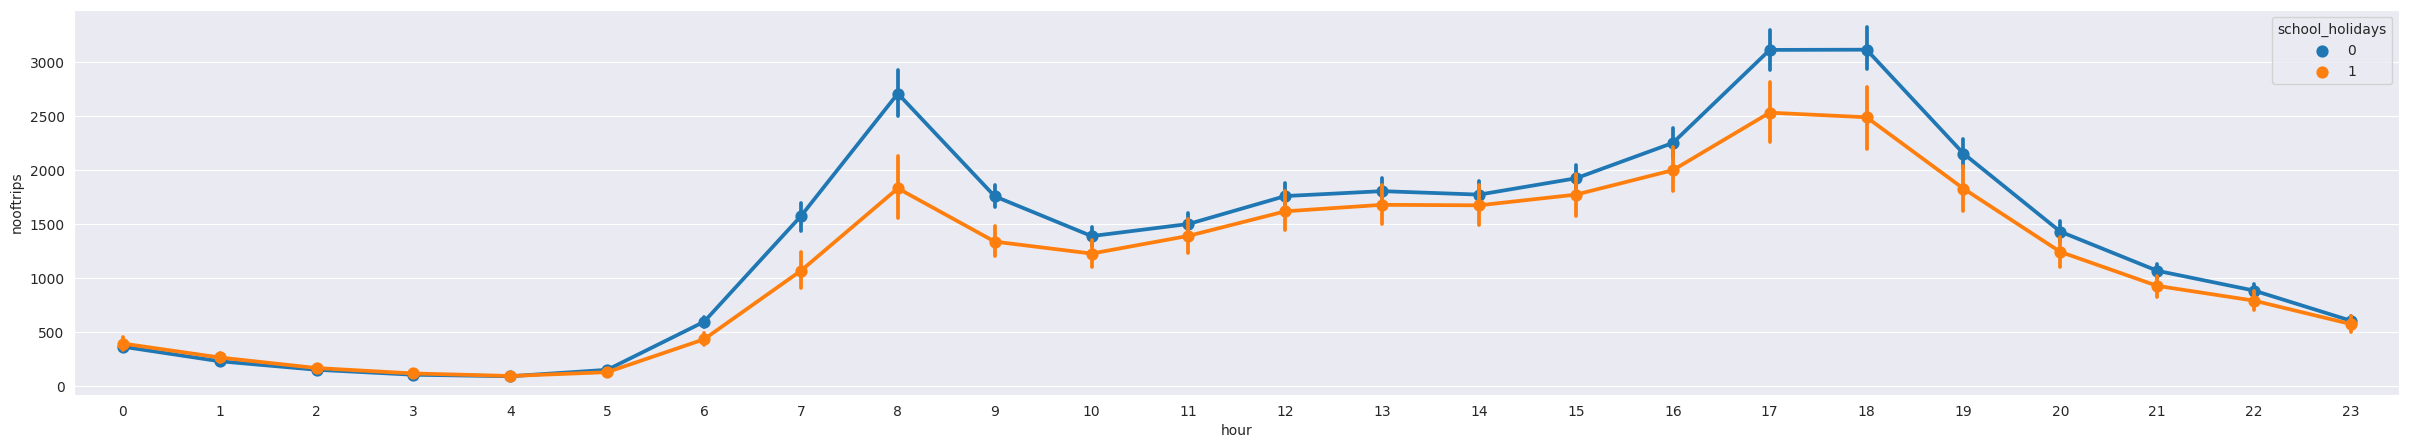

In [14]:
plt.figure(figsize=(30, 5))
sns.pointplot(x='hour', y='nooftrips', hue = 'school_holidays',data=df)

<Axes: xlabel='weekday', ylabel='nooftrips'>

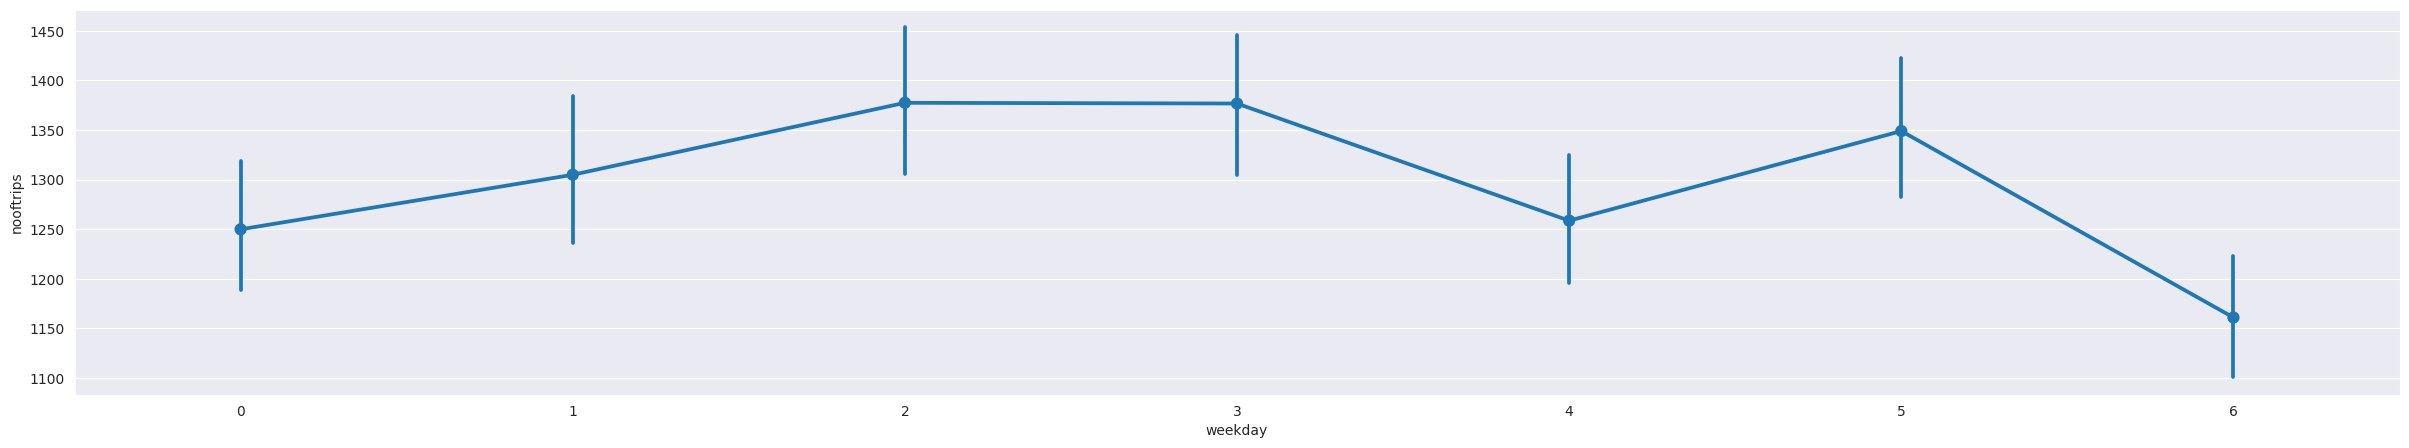

In [15]:
plt.figure(figsize=(30, 5))
sns.pointplot(x='weekday', y='nooftrips',data=df)

In [16]:
import math
# Get/Compute the number of rows to train the model on
training_data_len = math.ceil(len(df) *.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(8760, 13) (7884, 13) (900, 13)


In [17]:
from sklearn.preprocessing import RobustScaler

In [18]:
# # Scale the all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
# train_trans = train[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
# test_trans = test[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
# Robust_scale = RobustScaler().fit(train_trans)
# train.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.transform(train_trans)
# test.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.transform(test_trans)

In [19]:
#Scale the all of the data from columns ['nooftrips']
Robust_scale = RobustScaler().fit(train[['nooftrips']])
train['nooftrips'] = Robust_scale.transform(train[['nooftrips']])
test['nooftrips'] = Robust_scale.transform(test[['nooftrips']])

/tmp/ipykernel_63756/1192395762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['nooftrips'] = Robust_scale.transform(train[['nooftrips']])
/tmp/ipykernel_63756/1192395762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['nooftrips'] = Robust_scale.transform(test[['nooftrips']])


In [20]:
train.columns

Index(['nooftrips', 'temperature', 'rainfall', 'snowfall', 'cloudcover',
       'wind_speed', 'wind_direction', 'weekday', 'strike', 'school_holidays',
       'hour', 'day', 'month'],
      dtype='object')

In [21]:
train.to_numpy()
test.to_numpy()

array([[ 0.27034407,  0.72463768,  0.        , ..., 12.        ,
        25.        , 11.        ],
       [ 0.23375205,  0.76811594,  0.        , ..., 13.        ,
        25.        , 11.        ],
       [ 0.1561988 ,  0.79710145,  0.        , ..., 14.        ,
        25.        , 11.        ],
       ...,
       [-0.51338067,  0.6763285 ,  0.14285714, ..., 21.        ,
         1.        ,  1.        ],
       [-0.51829601,  0.67149758,  0.18367347, ..., 22.        ,
         1.        ,  1.        ],
       [-0.5445112 ,  0.66183575,  0.12244898, ..., 23.        ,
         1.        ,  1.        ]])

In [22]:
time_steps = 24

In [23]:
#Split the data into x_train and y_train data sets
X_train = []
y_train = []

for i in range(len(train) - time_steps):
    X_train.append(train.drop(columns='nooftrips').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'nooftrips'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [24]:
#Create the x_test and y_test data sets
X_test = []
y_test = df.loc[:,'nooftrips'].iloc[training_data_len:len(df)]

for i in range(len(test) - time_steps):
    X_test.append(test.drop(columns='nooftrips').iloc[i:i + time_steps].to_numpy())
    #y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

In [25]:
# [samples, time_steps, n_features]
# Using all 12 columns of data (take out the bike sharing amount column) to make prediction
print('Train data size:')
print(X_train.shape, y_train.shape)
print('Test data size:')
print(X_test.shape, y_test.shape)

Train data size:
(7860, 24, 12) (7860,)
Test data size:
(876, 24, 12) (876,)


In [26]:
#Build the LSTM network model
model = keras.Sequential()
model.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=50, activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(keras.layers.Dense(35))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(20))
model.add(keras.layers.Dense(15))
model.add(keras.layers.Dense(units=1))
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2023-09-04 13:15:54.574749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-04 13:15:54.652653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-09-04 13:15:54.652674: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-04 13:15:54.654538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=10, restore_best_weights=True)

In [28]:
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.15, shuffle=True, callbacks=[es])

Epoch 1/50
335/335 [==============================] - 10s 18ms/step - loss: 0.2992 - val_loss: 0.2389
Epoch 2/50
335/335 [==============================] - 6s 19ms/step - loss: 0.2137 - val_loss: 0.2183
Epoch 3/50
335/335 [==============================] - 6s 19ms/step - loss: 0.1739 - val_loss: 0.2261
Epoch 4/50
335/335 [==============================] - 7s 20ms/step - loss: 0.1423 - val_loss: 0.2372
Epoch 5/50
335/335 [==============================] - 7s 19ms/step - loss: 0.1269 - val_loss: 0.1773
Epoch 6/50
335/335 [==============================] - 6s 19ms/step - loss: 0.1077 - val_loss: 0.1802
Epoch 7/50
335/335 [==============================] - 7s 19ms/step - loss: 0.1027 - val_loss: 0.1598
Epoch 8/50
335/335 [==============================] - 7s 19ms/step - loss: 0.0914 - val_loss: 0.1644
Epoch 9/50
335/335 [==============================] - 7s 20ms/step - loss: 0.0912 - val_loss: 0.1460
Epoch 10/50
335/335 [==============================] - 7s 19ms/step - loss: 0.0769 - val_l

In [29]:
y_pred = model.predict(X_test)
y_pred = Robust_scale.inverse_transform(y_pred)#Undo scaling

28/28 [==============================] - 1s 6ms/step


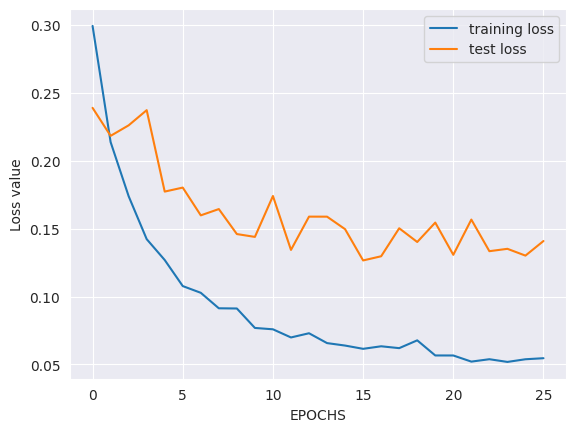

In [30]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend();

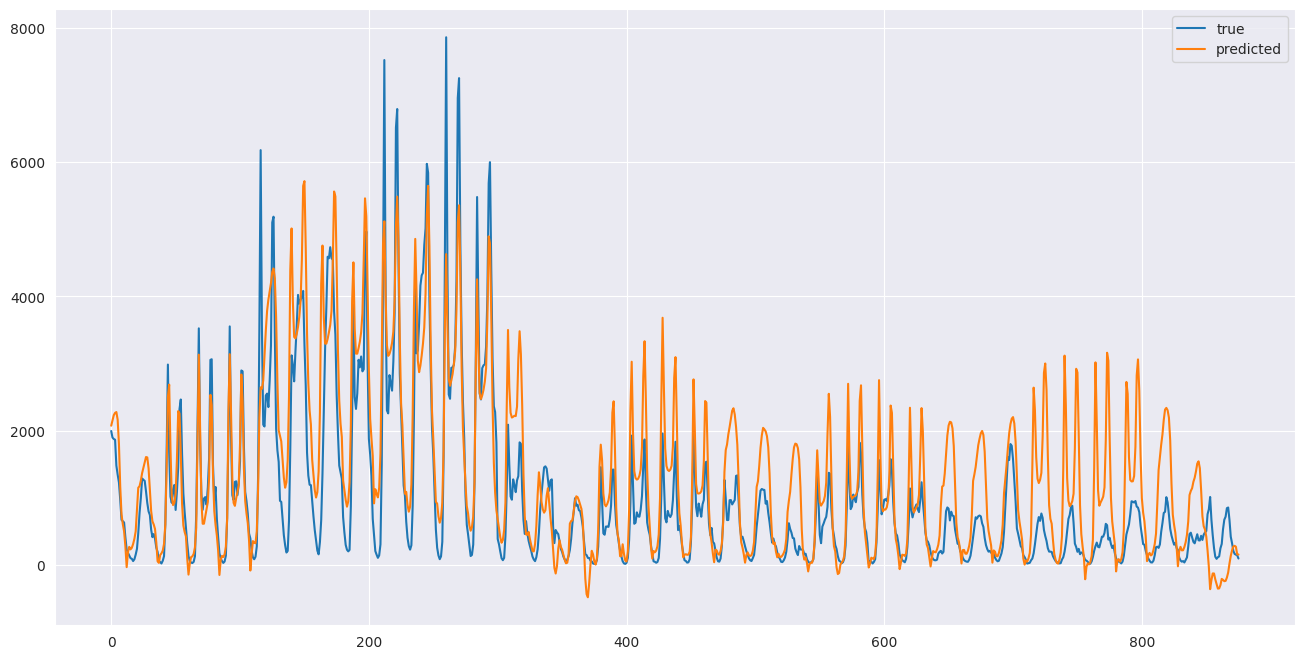

In [31]:
#Pcik some values to zoom in
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.legend()